In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

In [104]:
# Load NeuralNetwork class

import importlib
import NeuralNetwork

importlib.reload(NeuralNetwork)

from NeuralNetwork import Linear, Sigmoid, ReLU, BinaryCrossEntropyLoss, Sequential, save_weights, load_weights, \
    HyperbolicTangent

Weights loaded from saved_weights/sigmoid_xor_solved.w
Sigmoid Outputs:
[[0]
 [1]
 [1]
 [0]]
Weights loaded successfully
Weights loaded from saved_weights/tanh_xor_solved.w
Tangent Outputs:
[[0]
 [1]
 [1]
 [0]]
Weights loaded successfully


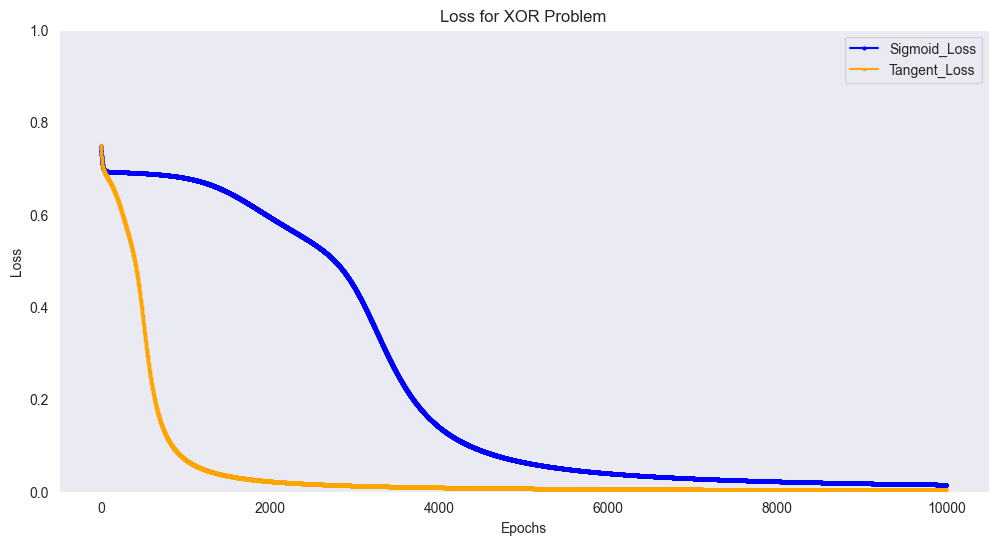

In [105]:
# XOR input and output
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Create the neural network model
model_sigmoid = Sequential()
model_sigmoid.add_layer(Linear(2, 2))
model_sigmoid.add_layer(Sigmoid())
model_sigmoid.add_layer(Linear(2, 1))
model_sigmoid.add_layer(Sigmoid())

epochs = 10000
learning_rate = 0.01
sigmoid_losses = []


def train_sigmoid():
    for epoch in range(1, epochs + 1):
        predicted = model_sigmoid.forward(X)

        loss_layer = BinaryCrossEntropyLoss()
        loss = loss_layer.forward_with_labels(predicted, y)
        sigmoid_losses.append(loss)

        loss_grad = loss_layer.backward_with_labels(predicted, y)
        model_sigmoid.backward(loss_grad)

        model_sigmoid.update(learning_rate)

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')

    predicted = model_sigmoid.forward(X)
    predicted_classes = (predicted > 0.5).astype(int)

    model_sigmoid.loss_history = sigmoid_losses
    print("Sigmoid Outputs:")
    print(predicted_classes)
    model_sigmoid.predicted_classes = predicted_classes
    save_weights(model_sigmoid, 'saved_weights/sigmoid_xor_solved.w')


try:
    load_weights(model_sigmoid, 'saved_weights/sigmoid_xor_solved.w')
    sigmoid_losses = model_sigmoid.loss_history
    print("Sigmoid Outputs:")
    print(model_sigmoid.predicted_classes)
    print('Weights loaded successfully')
except FileNotFoundError:
    print('Weights not loaded -> Training from scratch')
    train_sigmoid()

model_tangent = Sequential()
model_tangent.add_layer(Linear(2, 2))
model_tangent.add_layer(HyperbolicTangent())
model_tangent.add_layer(Linear(2, 1))
model_tangent.add_layer(Sigmoid())

tangent_losses = []


def train_tangent():
    for epoch in range(epochs):
        predicted = model_tangent.forward(X)

        loss_layer = BinaryCrossEntropyLoss()
        loss = loss_layer.forward_with_labels(predicted, y)
        tangent_losses.append(loss)

        loss_grad = loss_layer.backward_with_labels(predicted, y)
        model_tangent.backward(loss_grad)
        model_tangent.update(learning_rate)

        if epoch % 1000 == 0:
            print(f'Epoch {epoch},Loss: {loss}')

    predicted = model_tangent.forward(X)
    predicted_classes = (predicted > 0.5).astype(int)

    model_tangent.loss_history = tangent_losses
    print("Tangent Outputs:")
    print(predicted_classes)
    model_tangent.predicted_classes = predicted_classes
    save_weights(model_tangent, 'saved_weights/tanh_xor_solved.w')


try:
    load_weights(model_tangent, 'saved_weights/tanh_xor_solved.w')
    tangent_losses = model_tangent.loss_history
    print("Tangent Outputs:")
    print(model_tangent.predicted_classes)
    print('Weights loaded successfully')
except FileNotFoundError:
    print('Weights not loaded -> Training from scratch')
    train_tangent()

plt.figure(figsize=(12, 6))
plt.plot(sigmoid_losses, label='Sigmoid_Loss', color='blue', marker='o', markersize=2)
plt.plot(tangent_losses, label='Tangent_Loss', color='orange', marker='x', markersize=2)
plt.title('Loss for XOR Problem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

# Part 2: NYC Taxi Fare Prediction

In [106]:
# Loading dataset from nyc_taxi_data.npy
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]
X_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N


# Selecting the features to be used in the model

In [107]:
# Convert to Pandas DataFrames
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train, columns=["trip_duration"])  # Since y_train is a 1D array
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test, columns=["trip_duration"])  # Since y_test is a 1D array

X_train_df['pickup_datetime'] = pd.to_datetime(X_train_df['pickup_datetime'])
X_train_df['dropoff_datetime'] = pd.to_datetime(X_train_df['dropoff_datetime'])
X_test_df['pickup_datetime'] = pd.to_datetime(X_test_df['pickup_datetime'])
X_test_df['dropoff_datetime'] = pd.to_datetime(X_test_df['dropoff_datetime'])

# X_train_concat['trip_duration_seconds'] = (X_train_df['dropoff_datetime'] - X_train_df['pickup_datetime']).dt.total_seconds() / 3600
# X_train_df['trip_duration_seconds'] = (X_train_df['dropoff_datetime'] - X_train_df['pickup_datetime']).dt.total_seconds() / 3600
# X_test_df['trip_duration_seconds'] = (X_test_df['dropoff_datetime'] - X_test_df['pickup_datetime']).dt.total_seconds() / 3600


X_train_df['pickup_epoch_time'] = (X_train_df['pickup_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
X_train_df['dropoff_epoch_time'] = (X_train_df['dropoff_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

X_test_df['pickup_epoch_time'] = (X_test_df['pickup_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
X_test_df['dropoff_epoch_time'] = (X_test_df['dropoff_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

X_train_df['trip_duration_seconds'] = X_train_df['dropoff_epoch_time'] - X_train_df['pickup_epoch_time']
X_test_df['trip_duration_seconds'] = X_test_df['dropoff_epoch_time'] - X_test_df['pickup_epoch_time']

# dropping because they are non-numerical attributes
columns_to_drop = ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_epoch_time',
                   'dropoff_epoch_time', 'pickup_datetime', 'dropoff_datetime']
X_train_df = X_train_df.drop(columns=columns_to_drop, errors='ignore')
X_test_df = X_test_df.drop(columns=columns_to_drop, errors='ignore')

# Correlation Matrix

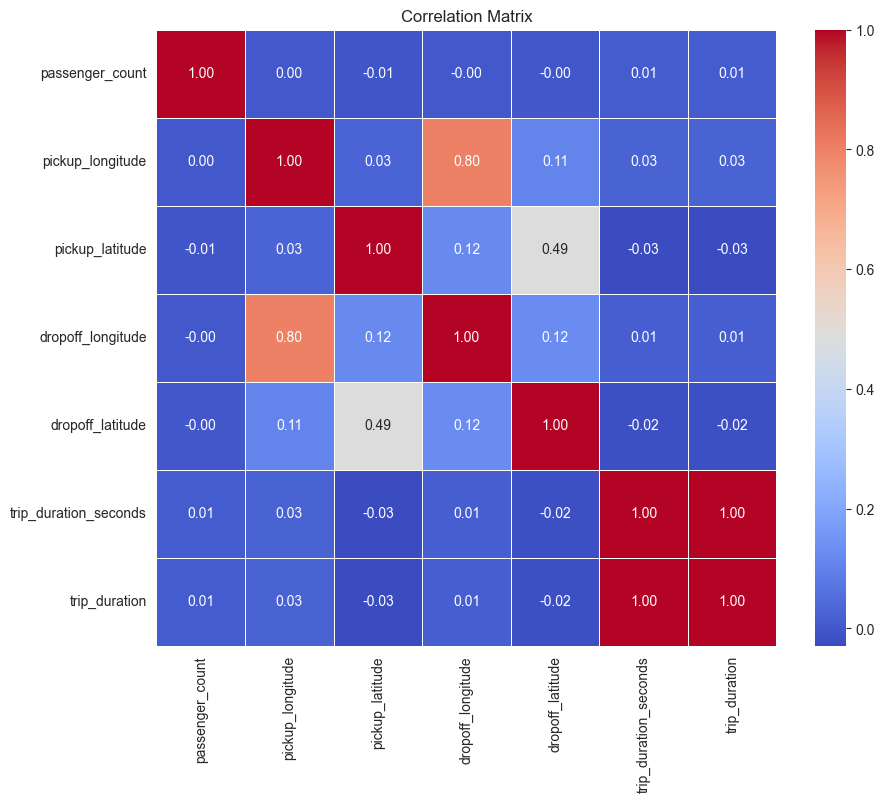

In [108]:
X_train_corr = X_train_df.copy()
# Concatenate the X_train and y_train dataframes
X_train_corr = pd.concat([X_train_df, y_train_df], axis=1)
# Compute the correlation matrix
corr_matrix = X_train_corr.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Feature Selection for Neural Network Training

### Target Attribute
The target attribute for the neural network model is **`trip_duration`**.

### Correlation Analysis
From the correlation matrix, it can be observed that:

- `trip_duration_seconds` and `trip_duration` have a perfect correlation (1.00), making one of them redundant.
- Other features show weak correlation with `trip_duration`, with values ranging between **0.01 to 0.03**, indicating minimal linear relationships.
- `pickup_longitude` and `dropoff_longitude` have a high correlation (0.80) with each other, suggesting that using both might introduce redundancy.
- `pickup_latitude` and `dropoff_latitude` exhibit a moderate correlation (0.49).

### Selected Features
Considering both correlation insights and potential non-linear dependencies that a neural network can learn, we select the following features:

- **`pickup_longitude`**
- **`pickup_latitude`**
- **`dropoff_longitude`**
- **`dropoff_latitude`**
- **`passenger_count`** (although weakly correlated, it might contribute under certain conditions)

### Additional Feature Engineering (Recommended)
Since no single feature shows a strong correlation with `trip_duration`, deriving additional features can enhance predictive performance:

1. **Haversine Distance** – The great-circle distance between pickup and dropoff locations.
2. **Day of the Week & Time of Day** – To capture variations due to traffic patterns.
3. **Weather Conditions** (if available) – Weather can significantly impact trip duration.
4. **Rush Hour Indicator** – Binary feature indicating whether the trip occurred during peak traffic hours.

By leveraging both raw and engineered features, the neural network can learn complex patterns beyond linear correlations.

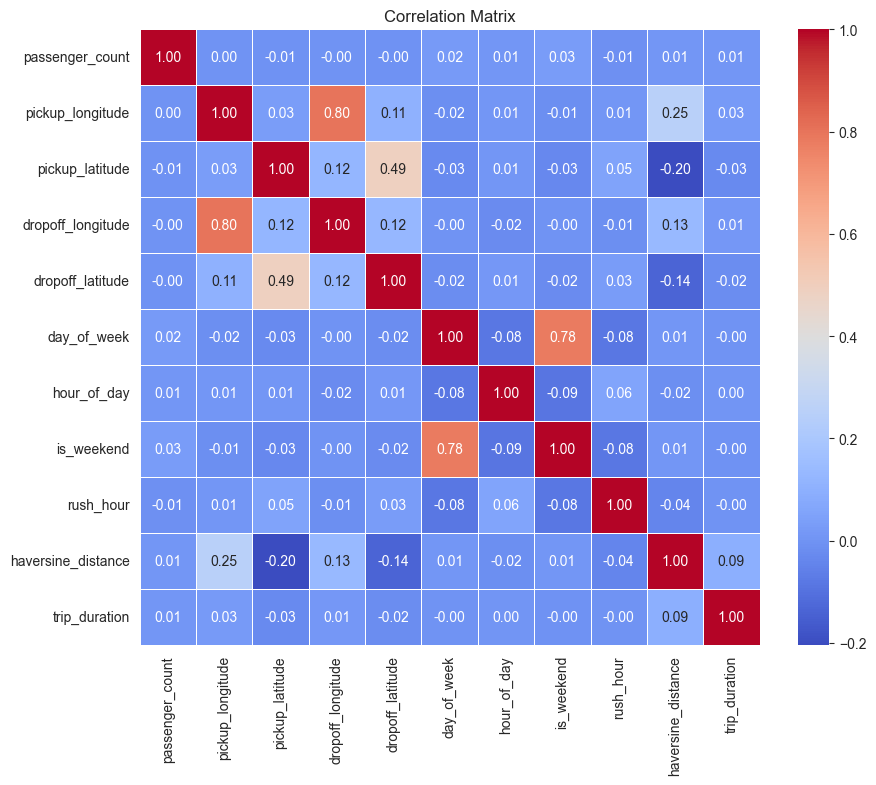

In [109]:
# Experimenting with additional derived features
X_train_additional = pd.DataFrame(X_train)
X_train_additional['pickup_datetime'] = pd.to_datetime(X_train_additional['pickup_datetime'])
X_train_additional['day_of_week'] = X_train_additional['pickup_datetime'].dt.dayofweek  # Monday = 0, Sunday = 6
X_train_additional['hour_of_day'] = X_train_additional['pickup_datetime'].dt.hour  # Extract hour
X_train_additional['is_weekend'] = X_train_additional['day_of_week'].apply(
    lambda x: 1 if x >= 5 else 0)  # Weekend indicator
X_train_additional['rush_hour'] = X_train_additional['hour_of_day'].apply(
    lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c  # Distance in km


# Apply function
X_train_additional['haversine_distance'] = X_train_additional.apply(lambda row: haversine(row['pickup_latitude'],
                                                                                          row['pickup_longitude'],
                                                                                          row['dropoff_latitude'],
                                                                                          row['dropoff_longitude']),
                                                                    axis=1)

columns_to_drop = ['id', 'vendor_id', 'store_and_fwd_flag', 'pickup_epoch_time', 'pickup_datetime', 'dropoff_datetime']
X_train_additional = X_train_additional.drop(columns=columns_to_drop, errors='ignore')

X_test_additional = pd.DataFrame(X_test)
X_test_additional['pickup_datetime'] = pd.to_datetime(X_test_additional['pickup_datetime'])
X_test_additional['day_of_week'] = X_test_additional['pickup_datetime'].dt.dayofweek  # Monday = 0, Sunday = 6
X_test_additional['hour_of_day'] = X_test_additional['pickup_datetime'].dt.hour  # Extract hour
X_test_additional['is_weekend'] = X_test_additional['day_of_week'].apply(
    lambda x: 1 if x >= 5 else 0)  # Weekend indicator
X_test_additional['rush_hour'] = X_test_additional['hour_of_day'].apply(
    lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

X_test_additional['haversine_distance'] = X_test_additional.apply(lambda row: haversine(row['pickup_latitude'],
                                                                                        row['pickup_longitude'],
                                                                                        row['dropoff_latitude'],
                                                                                        row['dropoff_longitude']),
                                                                  axis=1)

columns_to_drop = ['id', 'vendor_id', 'store_and_fwd_flag', 'pickup_epoch_time', 'pickup_datetime', 'dropoff_datetime']

X_test_additional = X_test_additional.drop(columns=columns_to_drop, errors='ignore')

X_train_additional = pd.concat([X_train_additional, y_train_df], axis=1)
# Compute the correlation matrix
corr_matrix = X_train_additional.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Feature Selection for Neural Network Training

## **Understanding the Correlation Matrix**
As I analyze the updated correlation matrix, I notice that no feature has a strong linear correlation with `trip_duration`. The highest correlation is **`haversine_distance` (0.09)**, which, while still low, is the most promising among the available features. This tells me that trip duration isn't directly influenced by any single variable but likely depends on a combination of factors.

### **Key Observations**
- **High Correlation Between Certain Features:**
  - `pickup_longitude` and `dropoff_longitude` have a correlation of **0.80**, which suggests they might carry similar information.
  - `day_of_week` and `is_weekend` are highly correlated (**0.78**), meaning one can be derived from the other.
  - `haversine_distance` shows some correlation with `pickup_longitude (0.25)`, which makes sense because trip distances depend on pickup locations.

With this in mind, I need to carefully select features that contribute meaningfully to predicting `trip_duration` while avoiding redundancy.

---

## **Features I’ve Selected for Training**
Since neural networks excel at capturing complex, non-linear relationships, I’ll keep features that might not have high direct correlation but still provide valuable information.

### **Features to Include**
1. **`pickup_longitude`** – Helps determine trip start location.
2. **`pickup_latitude`** – Complements longitude for precise geolocation.
3. **`dropoff_longitude`** – Identifies trip endpoint.
4. **`dropoff_latitude`** – Works with longitude to measure distance.
5. **`haversine_distance`** – The most directly relevant feature to trip duration.
6. **`hour_of_day`** – Captures potential traffic variations throughout the day.
8. **`passenger_count`** – Could impact duration due to stops or wait times.

### **Features I’ve Decided to Drop**
- **`day_of_week` vs. `is_weekend`** – Since weekends are derived from the day of the week, I only need one.
- **`trip_duration_seconds`** (if present) – Redundant with `trip_duration`.

---

## **Final Thoughts**
Looking at this dataset, I can see that simple linear correlations aren’t enough to determine which features matter most. Instead, I’m relying on my understanding of trip dynamics—things like distance, time of day effects—to guide my feature selection.

To further improve predictions, I’d consider adding external data like **weather conditions** and **real-time traffic** if available.


In [110]:
X_train_df['haversine_distance'] = X_train_additional['haversine_distance']
X_train_df['hour_of_day'] = X_train_additional['hour_of_day']

X_test_df['haversine_distance'] = X_test_additional['haversine_distance']
X_test_df['hour_of_day'] = X_test_additional['hour_of_day']

X_train_df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_seconds,haversine_distance,hour_of_day
879655,1,-73.955551,40.773346,-73.973640,40.763500,561,1.875964,23
646838,1,-73.962181,40.763599,-73.980377,40.764919,486,1.539475,9
1138713,1,-73.977486,40.751842,-74.011688,40.718925,1049,4.658508,16
864716,1,-73.970001,40.762363,-73.963264,40.774666,425,1.480942,11
434927,1,-73.950348,40.771561,-73.968178,40.762409,408,1.813886,9


# Cleaning Data
1. Handling NaN values
    - A common approach is to simply remove entire rows or columns that contain NaN values using functions like dropna() in Pandas.

In [111]:
y_train_df = np.log1p(y_train_df.to_numpy()).reshape(-1, 1)
y_test_df = np.log1p(y_test_df.to_numpy()).reshape(-1, 1)

X_train_df = pd.DataFrame(X_train_df).apply(pd.to_numeric, errors='coerce').dropna(axis=1)
X_test_df = pd.DataFrame(X_test_df).apply(pd.to_numeric, errors='coerce').dropna(axis=1)

print(X_train_df.dtypes)

passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
trip_duration_seconds      int64
haversine_distance       float64
hour_of_day                int32
dtype: object


In [112]:
# Plotting the distribution of the  data features
features = X_train_df.columns
print(features)

# for column in features:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(X_train_df[column], bins=30, kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.show()

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration_seconds',
       'haversine_distance', 'hour_of_day'],
      dtype='object')


# Dataset Preprocessing

In [113]:
# Additional normalization techniques
def decimal_scaling(X):
    max_abs = np.max(np.abs(X), axis=0)
    scale_factors = np.power(10, np.ceil(np.log10(max_abs + 1)))
    return X / scale_factors

scalers = {
    # "minmax": MinMaxScaler(),
    "zscore": StandardScaler()
    # "robust": RobustScaler(),
    # "maxabs": MaxAbsScaler(),
}

normalized_data = {}
for key, scaler in scalers.items():
    if callable(scaler):
        X_train_scaled = scaler(X_train_df.astype('float32'))
        X_test_scaled = scaler(X_test_df.astype('float32'))
    else:
        X_train_scaled = scaler.fit_transform(X_train_df.astype('float32'))
        X_test_scaled = scaler.transform(X_test_df.astype('float32'))

    X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_df, test_size=0.2,
                                                                  random_state=42)
    y_train_final = y_train_final.reshape(-1, 1)
    y_val = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val
    y_test_df = y_test_df.to_numpy() if isinstance(y_test_df, pd.Series) else y_test_df
    normalized_data[key] = (X_train_final, X_val, y_train_final, y_val, X_test_scaled, y_test)

print(normalized_data.keys())

dict_keys(['zscore'])


In [114]:
# Load model creation function

import importlib
import model

importlib.reload(model)

from model import train, mean_squared_error, mean_squared_log_error

In [115]:
def visualize_losses(train_loss_data, val_loss_data, label):
    plt.figure(figsize=(8, 5))
    plt.plot(np.log(train_loss_data), label="Train Loss")
    plt.plot(np.log(val_loss_data), label="Validation Loss")
    plt.title(f'{label} Training & Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{label.lower().replace(" ", "_")}.png')
    plt.show()

Training for zscore normalized data.
Epoch [1/20], Training Loss: 47.0839, Validation Loss: 30.6110
Epoch [2/20], Training Loss: 30.5590, Validation Loss: 19.9094
Epoch [3/20], Training Loss: 19.8717, Validation Loss: 15.1412
Epoch [4/20], Training Loss: 15.1082, Validation Loss: 12.1270
Epoch [5/20], Training Loss: 12.0973, Validation Loss: 10.1739
Epoch [6/20], Training Loss: 10.1466, Validation Loss: 8.8802
Epoch [7/20], Training Loss: 8.8546, Validation Loss: 8.0071
Epoch [8/20], Training Loss: 7.9827, Validation Loss: 7.4087
Epoch [9/20], Training Loss: 7.3852, Validation Loss: 6.9936
Epoch [10/20], Training Loss: 6.9707, Validation Loss: 6.7028
Epoch [11/20], Training Loss: 6.6804, Validation Loss: 6.4976
Epoch [12/20], Training Loss: 6.4756, Validation Loss: 6.3521
Epoch [13/20], Training Loss: 6.3303, Validation Loss: 6.2484
Epoch [14/20], Training Loss: 6.2268, Validation Loss: 6.1744
Epoch [15/20], Training Loss: 6.1529, Validation Loss: 6.1214
Epoch [16/20], Training Loss: 6

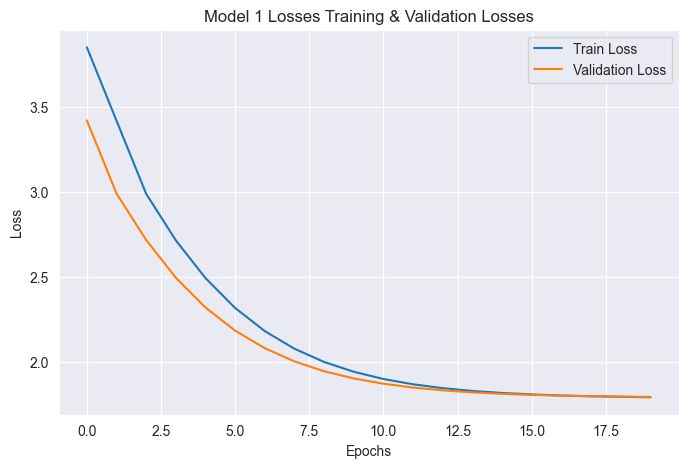

Training RMSE : 2.4497304116888245
Validation RMSE : 2.4519976240205703
Training RMSLE : 0.45558248146286895
Validation RMSLE : 0.45560488897543083
Test RMSE : 2.450243162596884
Test RMSLE : 0.4552682056045052


In [116]:
# Experiment with different model architectures and normalization techniques
for key, (X_train_final, X_val, y_train_final, y_val, X_test_scaled, y_test) in normalized_data.items():
    print(f"Training for {key} normalized data.")
    custom_model_1 = Sequential()
    custom_model_1.add_layer(Linear(X_train_final.shape[1], 4))
    custom_model_1.add_layer(ReLU())
    custom_model_1.add_layer(Linear(4, 16))
    custom_model_1.add_layer(ReLU())
    custom_model_1.add_layer(Linear(16, 32))
    custom_model_1.add_layer(ReLU())
    custom_model_1.add_layer(Linear(32, 16))
    custom_model_1.add_layer(ReLU())
    custom_model_1.add_layer(Linear(16, 4))
    custom_model_1.add_layer(ReLU())
    custom_model_1.add_layer(Linear(4, 1))

    # Train the model
    losses = train(custom_model_1, X_train_final, y_train_final, X_val, y_val, learning_rate=0.1, epochs=20)
    train_loss_1 = losses['training']
    val_loss_1 = losses['validation']
    train_msle_loss_1 = losses['train_msle']
    val_msle_loss_1 = losses['val_msle']

    # Visualize the loss history
    visualize_losses(train_loss_1, val_loss_1, 'Model 1 Losses')

    rmse_train_loss_1 = np.sqrt(train_loss_1[-1])
    rmse_val_loss_1 = np.sqrt(val_loss_1[-1])
    rmsle_train_loss_1 = np.sqrt(train_msle_loss_1[-1])
    rmsle_val_loss_1 = np.sqrt(val_msle_loss_1[-1])
    print(f"Training RMSE : {rmse_train_loss_1:}")
    print(f"Validation RMSE : {rmse_val_loss_1:}")
    print(f"Training RMSLE : {rmsle_train_loss_1:}")
    print(f"Validation RMSLE : {rmsle_val_loss_1:}")

    # Evaluate the model on the test set
    test_predictions = custom_model_1.forward(X_test_scaled)
    test_loss = mean_squared_error(test_predictions, y_test_df)
    test_msle_loss = mean_squared_log_error(test_predictions, y_test_df)
    rmse_test_loss = np.sqrt(test_loss)
    rmsle_test_loss = np.sqrt(test_msle_loss)
    print(f"Test RMSE : {rmse_test_loss:}")
    print(f"Test RMSLE : {rmsle_test_loss:}")

Training for zscore normalized data.
Epoch [1/20], Training Loss: 46.7230, Validation Loss: 17.5206
Epoch [2/20], Training Loss: 17.4851, Validation Loss: 7.2189
Epoch [3/20], Training Loss: 7.1957, Validation Loss: 3.3929
Epoch [4/20], Training Loss: 3.3769, Validation Loss: 2.2182
Epoch [5/20], Training Loss: 2.2054, Validation Loss: 1.8598
Epoch [6/20], Training Loss: 1.8483, Validation Loss: 1.7402
Epoch [7/20], Training Loss: 1.7291, Validation Loss: 1.6929
Epoch [8/20], Training Loss: 1.6819, Validation Loss: 1.6681
Epoch [9/20], Training Loss: 1.6572, Validation Loss: 1.6504
Epoch [10/20], Training Loss: 1.6396, Validation Loss: 1.6352
Epoch [11/20], Training Loss: 1.6245, Validation Loss: 1.6212
Epoch [12/20], Training Loss: 1.6105, Validation Loss: 1.6080
Epoch [13/20], Training Loss: 1.5973, Validation Loss: 1.5954
Epoch [14/20], Training Loss: 1.5848, Validation Loss: 1.5836
Epoch [15/20], Training Loss: 1.5730, Validation Loss: 1.5725
Epoch [16/20], Training Loss: 1.5620, V

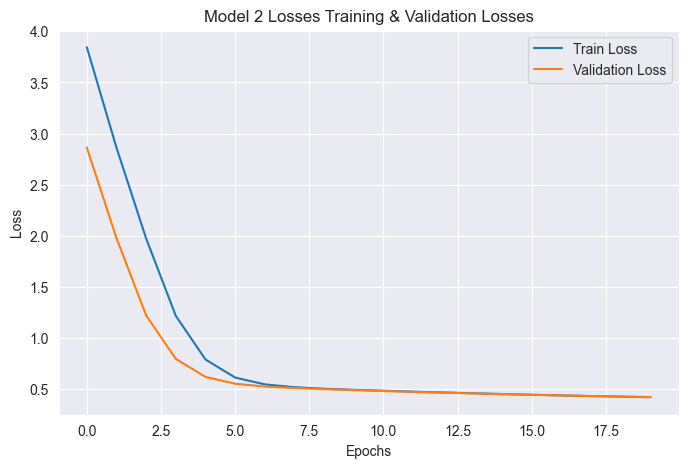

Training RMSE : 1.2349380276661277
Validation RMSE : 1.2361186164471007
Training RMSLE : 0.20099209287292943
Validation RMSLE : 0.20077493561615584
Test RMSE : 1.2355530322636414
Test RMSLE : 0.20065514079781546


In [117]:
for key, (X_train_final, X_val, y_train_final, y_val, X_test_scaled, y_test) in normalized_data.items():
    print(f"Training for {key} normalized data.")
    custom_model_2 = Sequential()
    custom_model_2.add_layer(Linear(X_train_final.shape[1], 8))
    custom_model_2.add_layer(Sigmoid())
    custom_model_2.add_layer(Linear(8, 8))
    custom_model_2.add_layer(Sigmoid())
    custom_model_2.add_layer(Linear(8, 4))
    custom_model_2.add_layer(Sigmoid())
    custom_model_2.add_layer(Linear(4, 1))
    # Train model, apply early stopping, and evaluate performance

    # Train the model
    losses = train(custom_model_2, X_train_final, y_train_final, X_val, y_val, learning_rate=0.1, epochs=20)
    train_loss_2 = losses['training']
    val_loss_2 = losses['validation']
    train_msle_loss_2 = losses['train_msle']
    val_msle_loss_2 = losses['val_msle']

    visualize_losses(train_loss_2, val_loss_2, 'Model 2 Losses')

    rmse_train_loss_2 = np.sqrt(train_loss_2[-1])
    rmse_val_loss_2 = np.sqrt(val_loss_2[-1])
    rmsle_train_loss_2 = np.sqrt(train_msle_loss_2[-1])
    rmsle_val_loss_2 = np.sqrt(val_msle_loss_2[-1])
    print(f"Training RMSE : {rmse_train_loss_2:}")
    print(f"Validation RMSE : {rmse_val_loss_2:}")
    print(f"Training RMSLE : {rmsle_train_loss_2:}")
    print(f"Validation RMSLE : {rmsle_val_loss_2:}")

    # Evaluate the model on the test set
    test_predictions = custom_model_2.forward(X_test_scaled)
    test_loss = mean_squared_error(test_predictions, y_test_df)
    test_msle_loss = mean_squared_log_error(test_predictions, y_test_df)
    rmse_test_loss = np.sqrt(test_loss)
    rmsle_test_loss = np.sqrt(test_msle_loss)
    print(f"Test RMSE : {rmse_test_loss:}")
    print(f"Test RMSLE : {rmsle_test_loss:}")

Training for zscore normalized data.
Epoch [1/20], Training Loss: 44.8215, Validation Loss: 8.3027
Epoch [2/20], Training Loss: 8.2611, Validation Loss: 1.5225
Epoch [3/20], Training Loss: 1.5027, Validation Loss: 1.1495
Epoch [4/20], Training Loss: 1.1303, Validation Loss: 0.9031
Epoch [5/20], Training Loss: 0.8907, Validation Loss: 0.7923
Epoch [6/20], Training Loss: 0.7820, Validation Loss: 0.7009
Epoch [7/20], Training Loss: 0.6933, Validation Loss: 0.6453
Epoch [8/20], Training Loss: 0.6388, Validation Loss: 0.5989
Epoch [9/20], Training Loss: 0.5935, Validation Loss: 0.5628
Epoch [10/20], Training Loss: 0.5579, Validation Loss: 0.5301
Epoch [11/20], Training Loss: 0.5258, Validation Loss: 0.5012
Epoch [12/20], Training Loss: 0.4972, Validation Loss: 0.4742
Epoch [13/20], Training Loss: 0.4706, Validation Loss: 0.4497
Epoch [14/20], Training Loss: 0.4464, Validation Loss: 0.4271
Epoch [15/20], Training Loss: 0.4240, Validation Loss: 0.4067
Epoch [16/20], Training Loss: 0.4038, Val

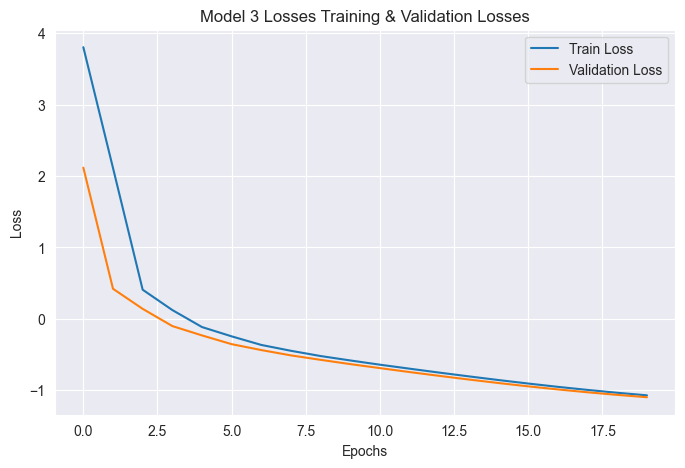

Training RMSE : 0.585105475691934
Validation RMSE : 0.5774503498584772
Training RMSLE : 0.10359627175779346
Validation RMSLE : 0.10193900798103461
Test RMSE : 0.5793213902095684
Test RMSLE : 0.10218139355866307


In [118]:
for key, (X_train_final, X_val, y_train_final, y_val, X_test_scaled, y_test) in normalized_data.items():
    print(f"Training for {key} normalized data.")
    custom_model_3 = Sequential()
    custom_model_3.add_layer(Linear(X_train_final.shape[1], 16))
    custom_model_3.add_layer(HyperbolicTangent())
    custom_model_3.add_layer(Linear(16, 16))
    custom_model_3.add_layer(HyperbolicTangent())
    custom_model_3.add_layer(Linear(16, 8))
    custom_model_3.add_layer(HyperbolicTangent())
    custom_model_3.add_layer(Linear(8, 1))
    # Train model, apply early stopping, and evaluate performance

    # Train the model
    losses = train(custom_model_3, X_train_final, y_train_final, X_val, y_val, learning_rate=0.01, epochs=20)
    train_loss_3 = losses['training']
    val_loss_3 = losses['validation']
    train_msle_loss_3 = losses['train_msle']
    val_msle_loss_3 = losses['val_msle']

    visualize_losses(train_loss_3, val_loss_3, 'Model 3 Losses')

    rmse_train_loss_3 = np.sqrt(train_loss_3[-1])
    rmse_val_loss_3 = np.sqrt(val_loss_3[-1])
    rmsle_train_loss_3 = np.sqrt(train_msle_loss_3[-1])
    rmsle_val_loss_3 = np.sqrt(val_msle_loss_3[-1])
    print(f"Training RMSE : {rmse_train_loss_3:}")
    print(f"Validation RMSE : {rmse_val_loss_3:}")
    print(f"Training RMSLE : {rmsle_train_loss_3:}")
    print(f"Validation RMSLE : {rmsle_val_loss_3:}")

    # Evaluate the model on the test set
    test_predictions = custom_model_3.forward(X_test_scaled)
    test_loss = mean_squared_error(test_predictions, y_test_df)
    test_msle_loss = mean_squared_log_error(test_predictions, y_test_df)
    rmse_test_loss = np.sqrt(test_loss)
    rmsle_test_loss = np.sqrt(test_msle_loss)
    print(f"Test RMSE : {rmse_test_loss:}")
    print(f"Test RMSLE : {rmsle_test_loss:}")

# Comparison of Activation Functions in Neural Network Models

## Results
The performance metrics for each activation function are shown above:

## Analysis

1. **ReLU Model Performance**
   - The ReLU model exhibits the highest RMSE and RMSLE values, indicating poor performance compared to the other models.
   - This suggests that ReLU is not the best choice for this particular dataset, possibly due to the presence of vanishing gradient issues or the model struggling to capture complex patterns.

2. **Sigmoid Model Performance**
   - The Sigmoid model significantly improves upon ReLU, with lower RMSE and RMSLE values across all datasets.
   - While it performs better, it is still outperformed by the Tanh model.

3. **Hyperbolic Tangent (Tanh) Model Performance**
   - The Tanh model shows the lowest RMSE and RMSLE values, making it the best-performing activation function in this experiment.
   - The consistency across training, validation, and test sets indicates good generalization ability.
   - Since Tanh is a scaled version of Sigmoid, it allows for a stronger gradient flow, which may explain its superior performance.

## Conclusion
Based on the results, the **Hyperbolic Tangent (Tanh) activation function performed the best**, achieving the lowest RMSE and RMSLE across all datasets. The Sigmoid model performed better than ReLU but was still outperformed by Tanh.

Further experimentation with hyperparameter tuning and alternative network architectures may enhance performance even further.

